In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from custom_model import UNET
from dataset import CarDataset
import custom_functions as cf
import pandas as pd


In [2]:
# Parameters model
BATCH_SIZE = 8
TRAIN_SPLIT = 0.8
LEARNING_RATE = 0.001
N_EPOCHS = 15

#### setting-up data for training

In [ ]:
# transform images
image_transform = transforms.Compose([
    transforms.CenterCrop((1280, 1912)), # Center to UNET compatible dimensions (divisible by 2^n)
    transforms.Resize((160, 240)),       # Resize by dividing both dimensions (divide by ~8)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])  # Normalize RGB images
])

# transform masks
mask_transform = transforms.Compose([
    transforms.CenterCrop((1280, 1912)), # Ensure same cropping as images
    transforms.Resize((160, 240)),       # Ensure same resizing as images
    transforms.ToTensor()                # Convert to tensor (values in [0, 1])
])

# Initialize dataset (and apply transformations)
dataset = CarDataset(
    image_dir="C:/Users/ygrae/Desktop/pytorch_unet/data/train",
    mask_dir="C:/Users/ygrae/Desktop/pytorch_unet/data/train_masks",
    image_transform=image_transform,
    mask_transform=mask_transform
)

# Split dataset into train and test
train_size = int(TRAIN_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(train_dataset))
print(len(test_dataset))

# Retain only 60% of the training and test datasets-------------------------------
# remove this part if you want to train on entire dataset
train_subset_indices = list(range(int(0.6 * len(train_dataset))))
test_subset_indices = list(range(int(0.6 * len(test_dataset))))

train_size = int(0.6 * len(train_dataset))
test_size = int(0.6 * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, train_subset_indices)
test_dataset = torch.utils.data.Subset(test_dataset, test_subset_indices)
# --------------------------------------------------------------------------------

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Sanity check
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")

    # Across channels
    for channel in range(images.shape[1]): 
        channel_data = images[:, channel, :, :]  
        print(f"Channel {channel}:")
        print(f"  Min: {channel_data.min().item():.4f}")
        print(f"  Max: {channel_data.max().item():.4f}")
        print(f"  Mean: {channel_data.mean().item():.4f}")
        print(f"  Std: {channel_data.std().item():.4f}")

    # For masks only one channel
    print(f"Mask values: Minimum {masks.min()} Maximum {masks.max()} Unique {masks.unique()}") # should be 0 and 1
    break
    

4070
1018
Image batch shape: torch.Size([8, 3, 160, 240])
Mask batch shape: torch.Size([8, 1, 160, 240])
Channel 0:
  Min: -2.0152
  Max: 2.2489
  Mean: 1.0484
  Std: 0.9452
Channel 1:
  Min: -1.9482
  Max: 2.4286
  Mean: 1.1793
  Std: 0.9852
Channel 2:
  Min: -1.7522
  Max: 2.6400
  Mean: 1.3569
  Std: 0.9756
Mask values: Minimum 0.0 Maximum 1.0 Unique tensor([0., 1.])


#### training UNET2D

In [4]:
# initialize model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet2D = UNET(n_class=1).to(device)

# loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy With Logits
optimizer = torch.optim.Adam(unet2D.parameters(),lr=LEARNING_RATE)

# intialize values for perfromance metrics
epoch_accuracy = []
epoch_ious = []
epoch_dices = []
epoch_losses = []

# training loop
for epoch in range(N_EPOCHS):
    # set model in training mode
    unet2D.train()

    # intialize values for metrics calculated each epoch
    TP, FP, FN, TN = 0, 0, 0, 0
    train_loss = 0.0
    i = 0

    for images, masks in train_loader: 
        images, masks = images.to(device), masks.to(device)

        # forward pass
        outputs = unet2D(images)
        loss = criterion(outputs, masks)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate loss
        train_loss += loss.item()

        # predictions
        predictions = torch.sigmoid(outputs) # sigmoid function squeezes outputs between 0 and 1
        thresholded_preds = (predictions > 0.5).float()

        # pixel-wise confusion matrix
        TP += (thresholded_preds * masks).sum().item()
        FP += (thresholded_preds * (1 - masks)).sum().item()
        FN += ((1 - thresholded_preds) * masks).sum().item()
        TN += ((1 - thresholded_preds) * (1 - masks)).sum().item() 

        # loop advancement
        #i += len(images)
        #if i % 800 == 0:
        #    print(f"Images Processed: {i}/{train_size}")
        
    # calculate metrics for the epoch
    avg_loss = train_loss / len(train_loader)
    avg_accuracy = (TP + TN) / (TP + TN + FP + FN)
    avg_iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0.0 # handle division by 0
    avg_dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0

    # Record metrics
    epoch_losses.append(avg_loss)
    epoch_accuracy.append(avg_accuracy)
    epoch_ious.append(avg_iou)
    epoch_dices.append(avg_dice)

    print(f"Epoch [{epoch+1}/{N_EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, IoU: {avg_iou:.4f}, Dice {avg_dice:.4f}")

# save model as state dictionary (i.e. dict mapping model layer to its parameter tensor)
model_save_path = "unet2D_model_15_60.pth"
config = {
    "model_name": "UNET",
    "input_channels": 3, 
    "output_classes": 1,
    "learning_rate": LEARNING_RATE,
    "epochs": N_EPOCHS
}

torch.save({'model_state_dict': unet2D.state_dict(), 'config': config}, model_save_path)

Epoch [1/15], Loss: 0.1384, Accuracy: 0.9487, IoU: 0.7844, Dice 0.8791
Epoch [2/15], Loss: 0.0296, Accuracy: 0.9882, IoU: 0.9461, Dice 0.9723
Epoch [3/15], Loss: 0.0234, Accuracy: 0.9911, IoU: 0.9588, Dice 0.9790
Epoch [4/15], Loss: 0.0197, Accuracy: 0.9924, IoU: 0.9646, Dice 0.9820
Epoch [5/15], Loss: 0.0134, Accuracy: 0.9948, IoU: 0.9757, Dice 0.9877
Epoch [6/15], Loss: 0.0519, Accuracy: 0.9934, IoU: 0.9692, Dice 0.9844
Epoch [7/15], Loss: 3.1076, Accuracy: 0.9019, IoU: 0.5902, Dice 0.7423
Epoch [8/15], Loss: 0.1408, Accuracy: 0.9466, IoU: 0.7710, Dice 0.8707
Epoch [9/15], Loss: 0.0983, Accuracy: 0.9629, IoU: 0.8384, Dice 0.9121
Epoch [10/15], Loss: 0.0721, Accuracy: 0.9730, IoU: 0.8801, Dice 0.9362
Epoch [11/15], Loss: 0.0660, Accuracy: 0.9759, IoU: 0.8922, Dice 0.9430
Epoch [12/15], Loss: 0.0690, Accuracy: 0.9747, IoU: 0.8868, Dice 0.9400
Epoch [13/15], Loss: 0.0628, Accuracy: 0.9767, IoU: 0.8954, Dice 0.9448
Epoch [14/15], Loss: 0.0629, Accuracy: 0.9774, IoU: 0.8982, Dice 0.9464
E

#### Pruning models and evaluating performance

In [5]:
# initialize model
unet2D = UNET(n_class=1).to(device)

# Load the checkpoint
model_save_path = "unet2D_model_15_60.pth"
checkpoint = torch.load(model_save_path)

# Load model state dictionary
unet2D.load_state_dict(checkpoint['model_state_dict'])

# loss function
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy With Logits

# pruning amounts
amounts = [0.1, 0.2, 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8]

# Initialize a list to store the results
results = []

# Baseline UNET2D separately
w0, zw0, f0, zf0 = cf.countWeightsAndFilters(unet2D)
avg_loss, avg_accuracy, avg_iou, avg_dice, inference_time = cf.evaluate_model(unet2D, test_loader=test_loader, criterion=criterion, device=device)

# Append baseline results
results.append({
    "Model": "Baseline",
    "Pruning_Type": "None",
    "Pruning_Amount": 0.0,
    "Total_Weights": w0,
    "Zero_Weights": zw0,
    "Total_Filters": f0,
    "Zero_Filters": zf0,
    "Loss": avg_loss, 
    "Accuracy": avg_accuracy, 
    "IoU": avg_iou, 
    "Dice": avg_dice, 
    "Inference Time (s)": inference_time
})

# Iterate through pruning amounts and methods
pruning_methods = [
    ("Structured Local L1", cf.structured_local),
    ("Unstructured Local L1", cf.unstructured_local),
    ("Unstructured Global L1", cf.unstructured_global),
    ("Structured Local Random", cf.structured_local_random),
    ("Unstructured Global Random", cf.unstructured_global_random),
    ("Unstructured Local Random", cf.unstructured_local_random)
]

for amount in amounts:
    for method_name, pruning_function in pruning_methods:
        # Apply pruning
        pruned_model = pruning_function(unet2D, amount=amount)
        
        # Count weights and filters
        w, zw, f, zf = cf.countWeightsAndFilters(pruned_model)
        
        # Evaluate the model
        avg_loss, avg_accuracy, avg_iou, avg_dice, inference_time = cf.evaluate_model(pruned_model, test_loader=test_loader, criterion=criterion, device=device)
        
        # Store the results
        results.append({
            "Model": "UNET2D",
            "Pruning_Type": method_name,
            "Pruning_Amount": amount,
            "Total_Weights": w,
            "Zero_Weights": zw,
            "Total_Filters": f,
            "Zero_Filters": zf,
            "Loss": avg_loss, 
            "Accuracy": avg_accuracy, 
            "IoU": avg_iou, 
            "Dice": avg_dice, 
            "Inference Time (s)": inference_time
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

C:\Users\ygrae\AppData\Local\Temp\ipykernel_2424\325797455.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_save_path)


In [18]:
results_df

,Model,Pruning_Type,Pruning_Amount,Total_Weights,Zero_Weights,Total_Filters,Zero_Filters,Loss,Accuracy,IoU,Dice,Inference Time (s)
0,Baseline,None,0.0,31031745,0,5889,0,0.067866,0.977160,0.899616,0.947156,143.260667
1,UNET2D,Structured Local L1,0.1,31031745,2818530,5889,588,0.150528,0.922979,0.728460,0.842901,143.749215
2,UNET2D,Unstructured Local L1,0.1,31031745,2823961,5889,0,0.061959,0.978330,0.903994,0.949576,145.708779
3,UNET2D,Unstructured Global L1,0.1,31031745,2823962,5889,0,0.068364,0.977112,0.899439,0.947057,144.399931
4,UNET2D,Structured Local Random,0.1,31031745,2818530,5889,588,0.912363,0.337094,0.207834,0.344143,145.383178
5,UNET2D,Unstructured Global Random,0.1,31031745,2823962,5889,0,3.295001,0.252874,0.207661,0.343906,144.143196
6,UNET2D,Unstructured Local Random,0.1,31031745,2823961,5889,0,0.527806,0.923797,0.662336,0.796874,145.452084
7,UNET2D,Structured Local L1,0.2,31031745,5642847,5889,1178,0.498881,0.784994,0.487170,0.655164,143.402441
8,UNET2D,Unstructured Local L1,0.2,31031745,5647924,5889,0,0.067235,0.975592,0.892770,0.943348,144.971013
9,UNET2D,Unstructured Global L1,0.2,31031745,5647923,5889,0,0.064818,0.977794,0.902027,0.948490,143.814550


#### create plots

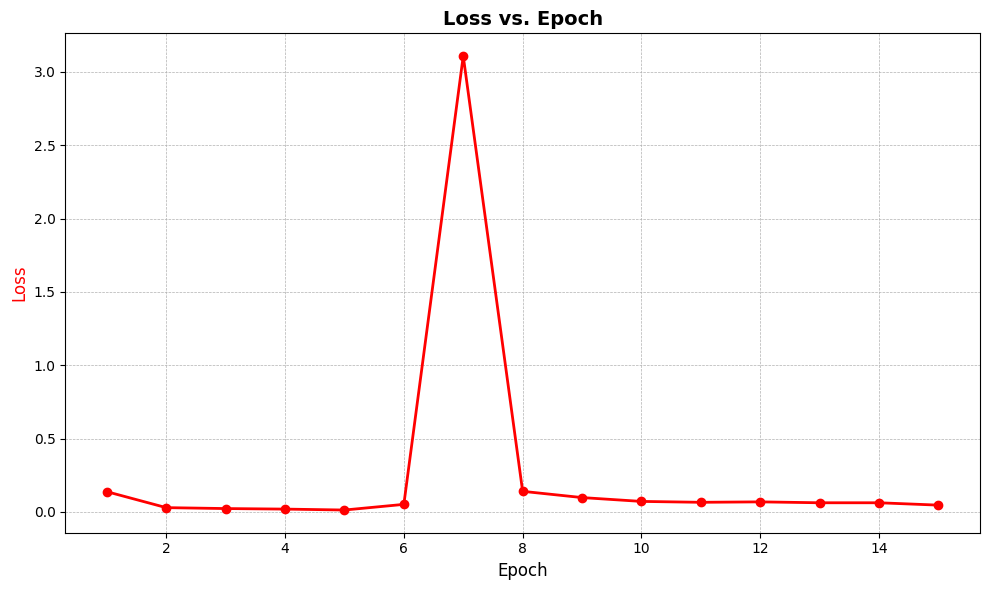

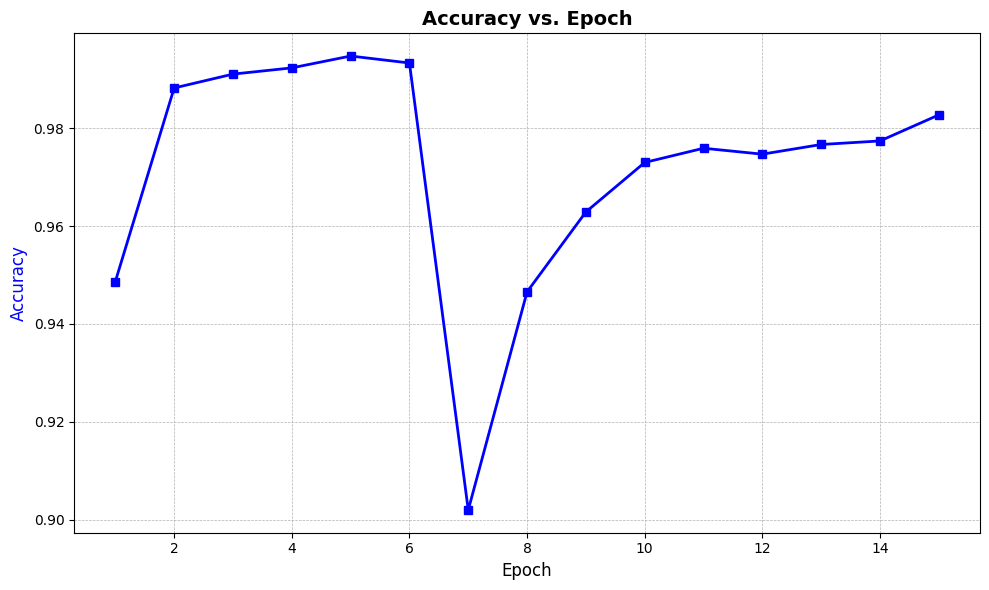

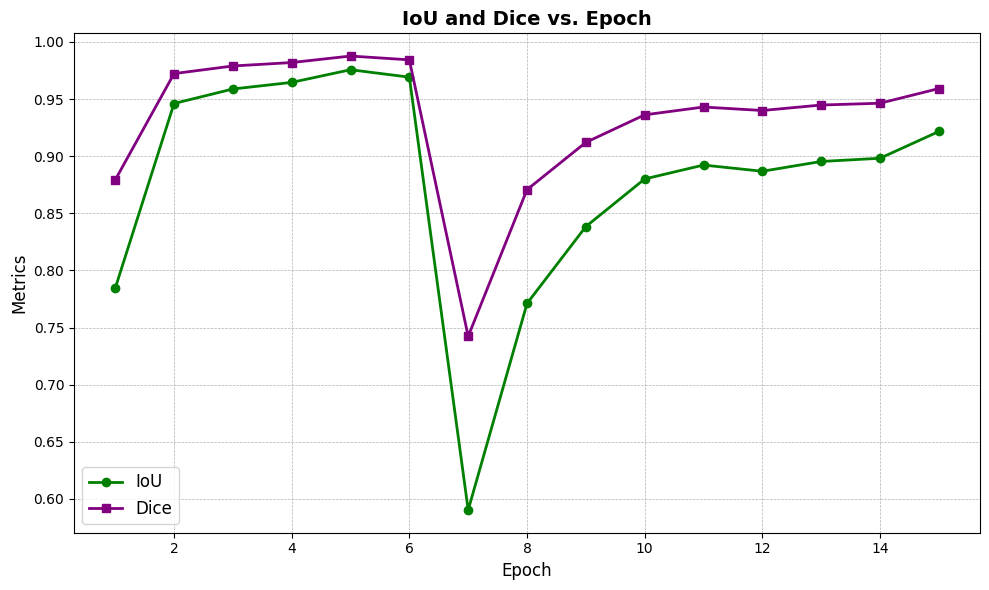

In [ ]:
# epoch training
epochs = list(range(1, N_EPOCHS+1))
 
# Plot Loss vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_losses, label='Loss', color='red', marker='o', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12, color='red')
plt.title('Loss vs. Epoch', fontsize=14, fontweight='bold')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot Accuracy vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_accuracy, label='Accuracy', color='blue', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12, color='blue')
plt.title('Accuracy vs. Epoch', fontsize=14, fontweight='bold')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot IoU and Dice on the same plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_ious, label='IoU', color='green', marker='o', linewidth=2)
plt.plot(epochs, epoch_dices, label='Dice', color='purple', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.title('IoU and Dice vs. Epoch', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

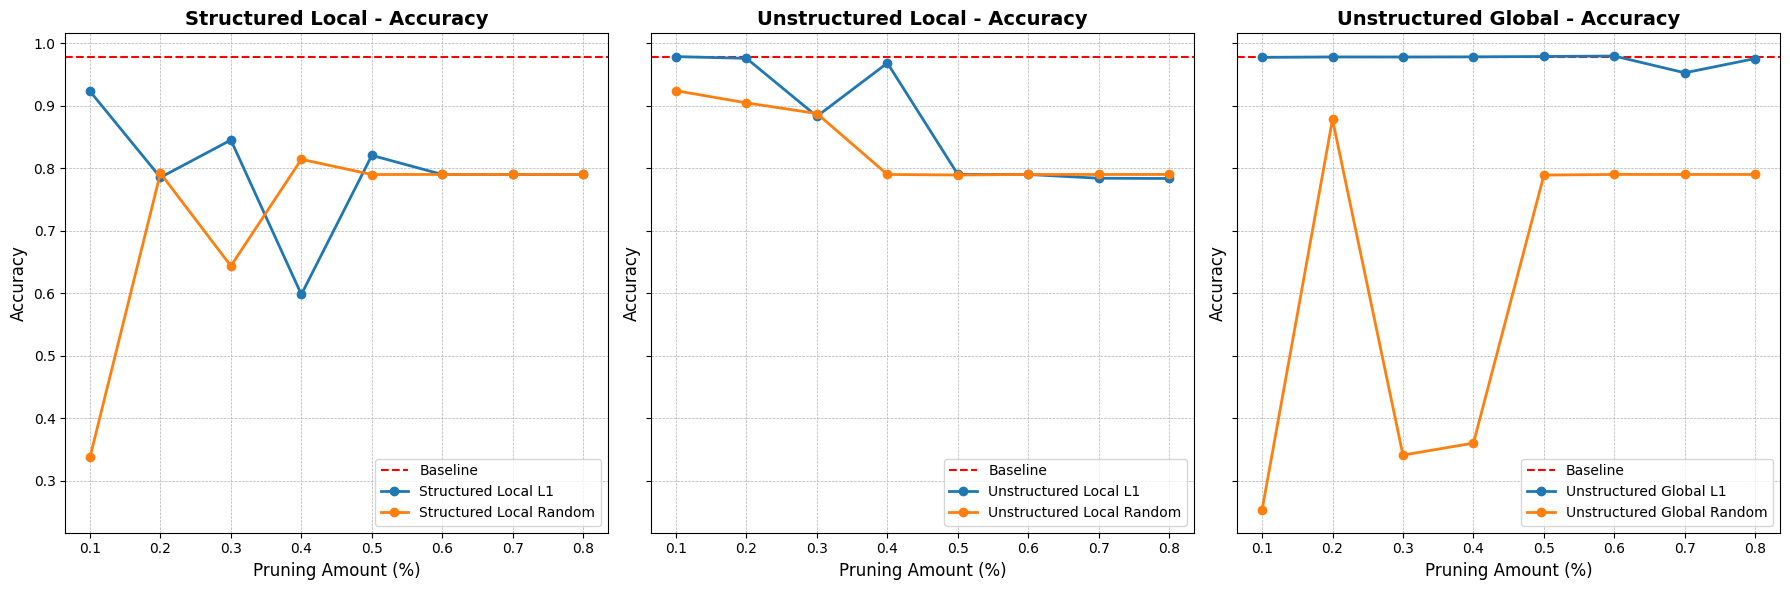

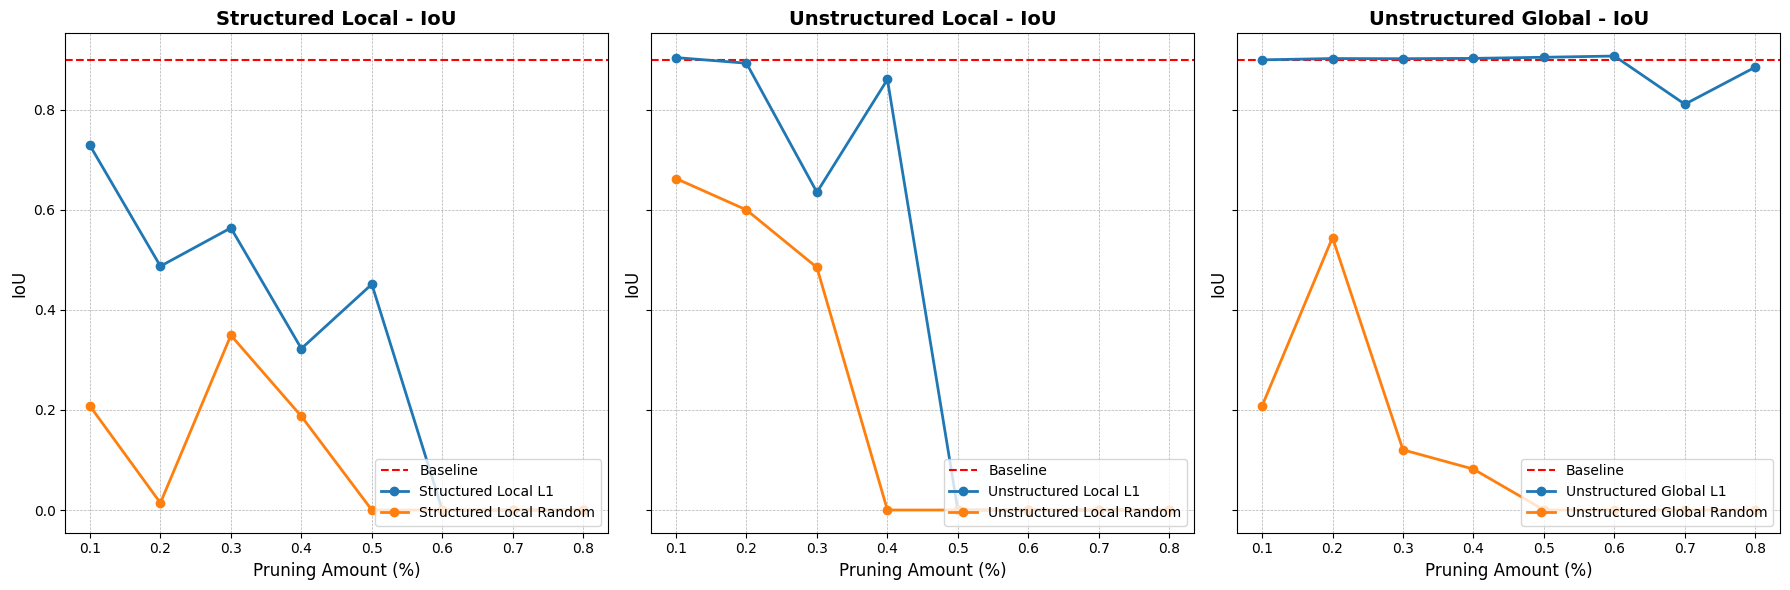

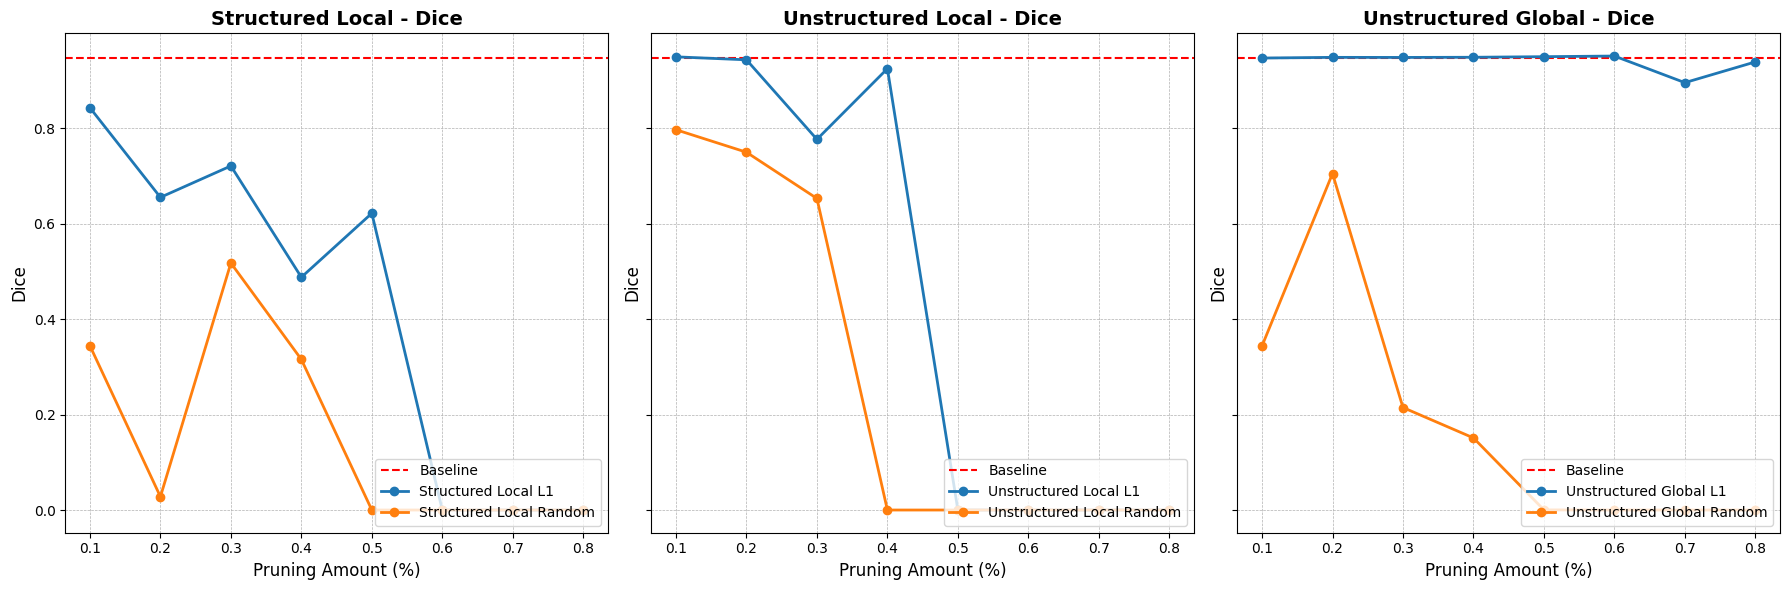

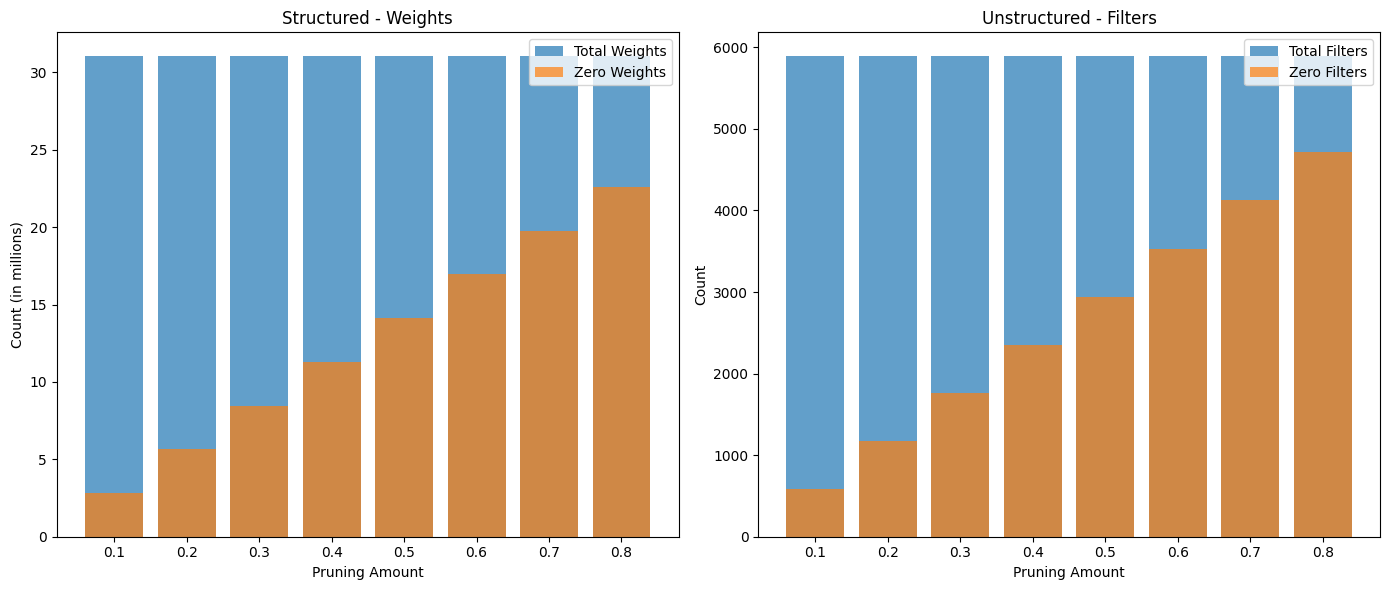

In [44]:
df = results_df

# Extract baseline metrics for reference lines
baseline_accuracy = df[df["Model"] == "Baseline"]["Accuracy"].values[0]
baseline_iou = df[df["Model"] == "Baseline"]["IoU"].values[0]
baseline_dice = df[df["Model"] == "Baseline"]["Dice"].values[0]

# Adjusting the code to create separate figures for each metric

# Define pruning groups
pruning_groups = {
    "Structured Local": ["Structured Local L1", "Structured Local Random"],
    "Unstructured Local": ["Unstructured Local L1", "Unstructured Local Random"],
    "Unstructured Global": ["Unstructured Global L1", "Unstructured Global Random"],
}

# Metrics and corresponding baseline values
metrics = ["Accuracy", "IoU", "Dice"]
baselines = [baseline_accuracy, baseline_iou, baseline_dice]

# Create a separate figure for each metric
for metric, baseline in zip(metrics, baselines):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Single row with 3 subplots
    for ax, (group_title, pruning_types) in zip(axes, pruning_groups.items()):
        ax.axhline(y=baseline, color="red", linestyle="--", label="Baseline")
        for pruning_type in pruning_types:
            subset = df[df["Pruning_Type"] == pruning_type]
            ax.plot(
                subset["Pruning_Amount"],
                subset[metric],
                marker="o",
                label=pruning_type,
                linewidth=2,
            )
        ax.set_xlabel("Pruning Amount (%)", fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f"{group_title} - {metric}", fontsize=14, fontweight="bold")
        ax.legend(fontsize=10, loc="lower right")  # Place legend consistently in the bottom-right corner
        ax.grid(visible=True, linestyle="--", linewidth=0.5)
    
    fig.tight_layout()
    plt.show()


# Create plot of amount of filters and weights 

# Filtering the data
structured_data = results_df[results_df["Pruning_Type"] == "Structured Local L1"]
unstructured_data = results_df[results_df["Pruning_Type"] == "Unstructured Global L1"]

# Plotting
# Updating the plots with the new requirements

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Left Plot: Zero Weights and Total Weights (scaled to millions)
axes[0].bar(
    unstructured_data["Pruning_Amount"].astype(str),
    unstructured_data["Total_Weights"] / 1e6,
    label="Total Weights",
    alpha=0.7,
)
axes[0].bar(
    unstructured_data["Pruning_Amount"].astype(str),
    unstructured_data["Zero_Weights"] / 1e6,
    label="Zero Weights",
    alpha=0.7,
)
axes[0].set_title("Structured - Weights")
axes[0].set_xlabel("Pruning Amount")
axes[0].set_ylabel("Count (in millions)")
axes[0].legend()

# Right Plot: Zero Filters and Total Filters
axes[1].bar(
    structured_data["Pruning_Amount"].astype(str),
    structured_data["Total_Filters"],
    label="Total Filters",
    alpha=0.7,
)
axes[1].bar(
    structured_data["Pruning_Amount"].astype(str),
    structured_data["Zero_Filters"],
    label="Zero Filters",
    alpha=0.7,
)
axes[1].set_title("Unstructured - Filters")
axes[1].set_xlabel("Pruning Amount")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()
